### Dataset Description

The data comes from Amazon Inc. collected from 2010-2011 (published on Kaggle platform). The training set consists of 32769 samples and the testing one of 58922 samples. The training set has one label attribute named “ACTION”, whose value “1” indicates an application is approved whereas “0” indicates rejection. As predictors of this state, there are eight features, indicating characteristics of the required resource anf the role and work group of the employee at Amazon requesting access.

**train.csv** - The training set. Each row has the ACTION (ground truth), RESOURCE, and information about the employee's role at the time of approval

**test.csv** - The test set for which predictions should be made. Each row asks whether an employee having the listed characteristics should have access to the listed resource.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [3]:
train.dtypes

ACTION              int64
RESOURCE            int64
MGR_ID              int64
ROLE_ROLLUP_1       int64
ROLE_ROLLUP_2       int64
ROLE_DEPTNAME       int64
ROLE_TITLE          int64
ROLE_FAMILY_DESC    int64
ROLE_FAMILY         int64
ROLE_CODE           int64
dtype: object

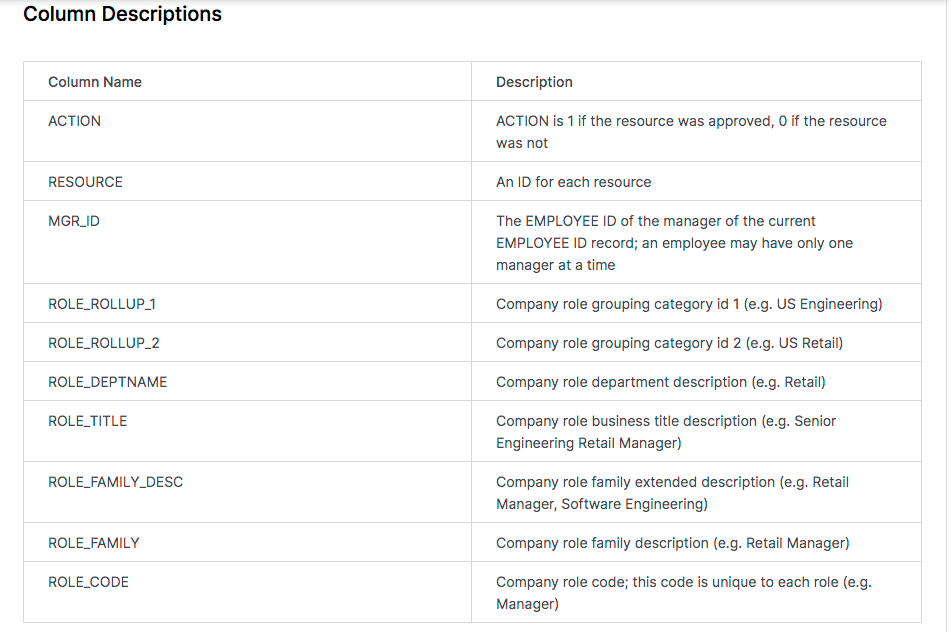

In [4]:
# Convert all features'type to object, except "Action"
train_o = train.copy()

# Categorical features
cat_features = list(train_o.columns[1:])
train_o[cat_features] = train_o[cat_features].astype(str)
train_o.dtypes

ACTION               int64
RESOURCE            object
MGR_ID              object
ROLE_ROLLUP_1       object
ROLE_ROLLUP_2       object
ROLE_DEPTNAME       object
ROLE_TITLE          object
ROLE_FAMILY_DESC    object
ROLE_FAMILY         object
ROLE_CODE           object
dtype: object

In [5]:
train_o.describe(include="O")

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
count,32769,32769,32769,32769,32769,32769,32769,32769,32769
unique,7518,4243,128,177,449,343,2358,67,343
top,4675,770,117961,118300,117878,118321,117906,290919,118322
freq,839,152,21407,4424,1135,4649,6896,10980,4649


Naturally, one-hot encoding can be used to solve non-order categorical data. **Since many unique values for each column, one-hot encoding can cause "curse of dimensionality"**. Therefore, we need a technique to prevent this problem.

In [6]:
# Convert all features'type to object, except "Action"
test_o = test.copy()

# Categorical features
cat_features = list(test_o.columns[1:])
test_o[cat_features] = test_o[cat_features].astype(str)
test_o.dtypes

id                   int64
RESOURCE            object
MGR_ID              object
ROLE_ROLLUP_1       object
ROLE_ROLLUP_2       object
ROLE_DEPTNAME       object
ROLE_TITLE          object
ROLE_FAMILY_DESC    object
ROLE_FAMILY         object
ROLE_CODE           object
dtype: object

In [7]:
test_o.describe(include="O")

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
count,58921,58921,58921,58921,58921,58921,58921,58921,58921
unique,4971,4689,126,177,466,351,2749,68,351
top,4675,770,117961,118300,117878,118321,117906,290919,118322
freq,1989,276,37658,7731,2261,7433,11100,17881,7433


In [8]:
print(f"Shape of train data: {train.shape}")
print(f"Shape of test data: {test.shape}")

Shape of train data: (32769, 10)
Shape of test data: (58921, 10)


In [9]:
train_o.isnull().sum()

ACTION              0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64

In [10]:
test_o.isnull().sum()

id                  0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64

There is no missing value in both data

### Data Exploration

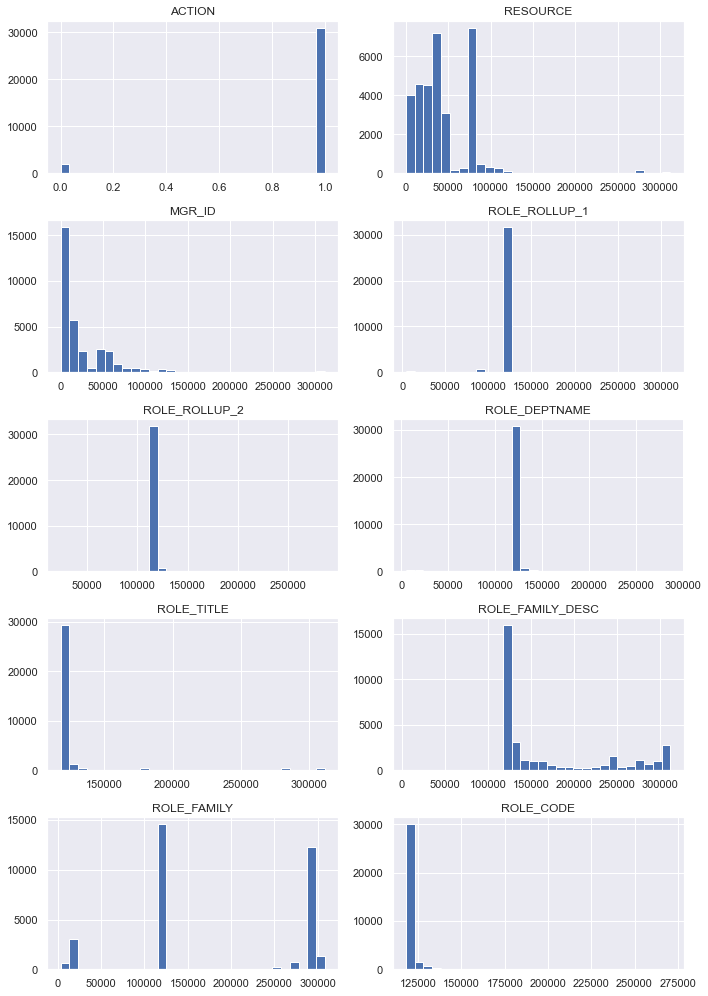

In [11]:
train.hist(bins=30, figsize=(10, 14), layout=(5, 2))
plt.tight_layout()
plt.show()

Most of **Resources and Managers** are concentrated on **ID which is less than 50000**.

<AxesSubplot:>

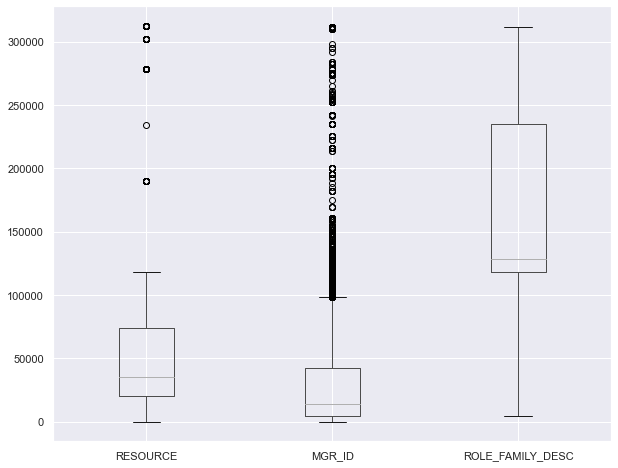

In [12]:
# See a distribution of considered features
considered_cols = ["RESOURCE", "MGR_ID", "ROLE_FAMILY_DESC"]
train[considered_cols].boxplot(figsize=(10, 8))

It seems that "Resource" and "MGR_ID" are highly-correlated. In logical way, **outlying "Resource" means significant and confidential resources, while outlying "MGR_ID" means higher job position in company**. 

Then, **only most of higher employee can work on confidential resources**.

In [13]:
train_o["ACTION"].value_counts()

1    30872
0     1897
Name: ACTION, dtype: int64

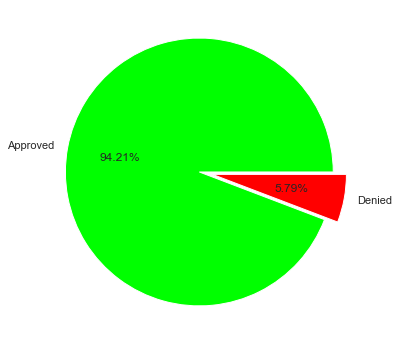

In [14]:
counts_data = train_o["ACTION"].value_counts()
labels = ["Approved", "Denied"]
colors = ["lime", "red"]

plt.figure(figsize=(6, 8))
plt.pie(counts_data, explode=(0.1, 0), labels=labels, colors=colors, autopct='%.2f%%')
plt.show()

This machine learning problem meets another problem, **class imbalance**.

### Model Building (1)

In [15]:
from sklearn.model_selection import train_test_split
X = train.drop("ACTION", axis=1)
Y = train["ACTION"]

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=.2, random_state=42)

In [16]:
from catboost import CatBoostClassifier

# Without cat_features
cbc_wo_cat = CatBoostClassifier(loss_function="Logloss", eval_metric="Accuracy", random_seed=1, verbose=200, n_estimators=500)
cbc_wo_cat.fit(X_train, Y_train,
        eval_set=(X_valid, Y_valid),
        use_best_model=True
       )

Learning rate set to 0.095993
0:	learn: 0.9417128	test: 0.9436985	best: 0.9436985 (0)	total: 149ms	remaining: 1m 14s
200:	learn: 0.9470532	test: 0.9453769	best: 0.9453769 (192)	total: 2.65s	remaining: 3.94s
400:	learn: 0.9552546	test: 0.9481233	best: 0.9485810 (388)	total: 4.98s	remaining: 1.23s
499:	learn: 0.9575434	test: 0.9494965	best: 0.9494965 (498)	total: 6.18s	remaining: 0us

bestTest = 0.9494964907
bestIteration = 498

Shrink model to first 499 iterations.


### Model Building (2)

In [17]:
X = train_o.drop("ACTION", axis=1)
Y = train_o["ACTION"]

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=.2, random_state=42)

In [18]:
cat_features

['RESOURCE',
 'MGR_ID',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_2',
 'ROLE_DEPTNAME',
 'ROLE_TITLE',
 'ROLE_FAMILY_DESC',
 'ROLE_FAMILY',
 'ROLE_CODE']

In [19]:
# With cat_features
cbc = CatBoostClassifier(loss_function="Logloss", 
                         eval_metric="Accuracy", 
                         random_seed=1, 
                         verbose=200, 
                         n_estimators=500, 
                         cat_features=cat_features)
cbc.fit(X_train, Y_train,
        eval_set=(X_valid, Y_valid),
        use_best_model=True
       )

Learning rate set to 0.095993
0:	learn: 0.9417128	test: 0.9436985	best: 0.9436985 (0)	total: 57.9ms	remaining: 28.9s
200:	learn: 0.9589167	test: 0.9572780	best: 0.9572780 (186)	total: 19.6s	remaining: 29.2s
400:	learn: 0.9625787	test: 0.9569728	best: 0.9578883 (269)	total: 40.2s	remaining: 9.94s
499:	learn: 0.9639519	test: 0.9574306	best: 0.9578883 (269)	total: 51.7s	remaining: 0us

bestTest = 0.9578883125
bestIteration = 269

Shrink model to first 270 iterations.


**Specifying which features are categorical can affect model's perfomance significantly**

### Model Evaluation

In [20]:
Y_valid.value_counts()

1    6185
0     369
Name: ACTION, dtype: int64

In [21]:
from sklearn.metrics import confusion_matrix

pred_wo = cbc_wo_cat.predict(X_valid)
cm_wo = confusion_matrix(Y_valid, pred_wo)
df_cm_wo = pd.DataFrame(cm_wo, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

df_cm_wo

,Predicted 0,Predicted 1
Actual 0,67,302
Actual 1,29,6156


In [22]:
pred = cbc.predict(X_valid)
cm = confusion_matrix(Y_valid, pred)
df_cm = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

df_cm

,Predicted 0,Predicted 1
Actual 0,155,214
Actual 1,62,6123


In [23]:
spec = df_cm.iloc[0, 0] / np.sum(df_cm, axis=0)[0]
recall = df_cm.iloc[1, 1] / np.sum(df_cm, axis=0)[1]
prec = df_cm.iloc[1, 1] / np.sum(df_cm, axis=1)[1]

metrics = [("Specificity", spec), ("Recall", recall), ("Precision", prec)]
for name, metric in metrics:
    print(f"{name} of cbc model: {metric}")

Specificity of cbc model: 0.7142857142857143
Recall of cbc model: 0.9662300773236547
Precision of cbc model: 0.9899757477768796


### Logistic Regression and PCA

In [24]:
from sklearn.decomposition import PCA

# One Hot Encoding
X_train = pd.get_dummies(X_train)

# PCA
pca = PCA()
pca_data = pca.fit_transform(X_train)

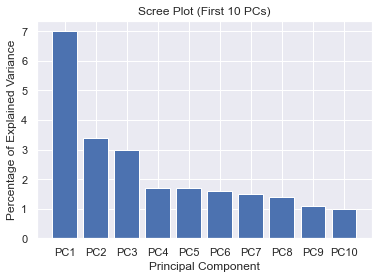

In [25]:
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = [f"PC{i}" for i in range(1, len(per_var)+1)]

plt.bar(x=range(1, 10+1), height=per_var[:10], tick_label=labels[:10])
plt.ylabel("Percentage of Explained Variance")
plt.xlabel("Principal Component")
plt.title("Scree Plot (First 10 PCs)")
plt.show()

In [26]:
print(f"First Ten PCs account for {round(sum(per_var[:10]), 2)}% (from {round(sum(per_var), 2)}%) variation")

First Ten PCs account for 23.4% (from 69.0%) variation


**Even using all of PCs, they doesn't account 100% (or 69%) variation**. So, the prediction will be not accurate using PCA.